<a href="https://colab.research.google.com/github/voshna123/med_sumarry/blob/main/med_sum_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-17 05:37:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-17 05:37:31 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import calculate_results,create_tensorboard_callback

In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [6]:
import os

filenames = [data_dir + "/"+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

#Preprocess Data

In [7]:
def get_lines(filename):
  """
  Reads filename and return the lines of text as a list

  Args:
  filename

  Returns:
  List of lines
  """

  with open(filename, "r") as f:
    return f.read().splitlines()

In [8]:
train_lines = get_lines(filenames[1])
train_lines[0:10]

['###24293578',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensiti

In [9]:
from inspect import currentframe
def preprocesses_line(filename):
  """
  Returns list of dictionaries
  """

  input_line = get_lines(filename)
  text = []
  category =[]
  line_nums = []
  max_lines =[]


  curr_max= 0

  for line in input_line:
    if not '###' in line:
      if line == "":
        for x in range(curr_max):
          max_lines.append(curr_max)
        continue
      else:
        curr_max += 1
        line_nums.append(line_number)
        line_number += 1
        split = line.split("\t")
        category.append(split[0])
        text.append(split[1])

    else:

      line_number =0
      curr_max = 0


  return {"line_number": line_nums, "text": text, "category": category, "max" :max_lines}

In [10]:
import pandas as pd
test_df = pd.DataFrame(preprocesses_line(filenames[0]))
txt_dict_train = preprocesses_line(filenames[1])
val_df = pd.DataFrame(preprocesses_line(filenames[2]))
train_df = pd.DataFrame(txt_dict_train)

<Axes: ylabel='Frequency'>

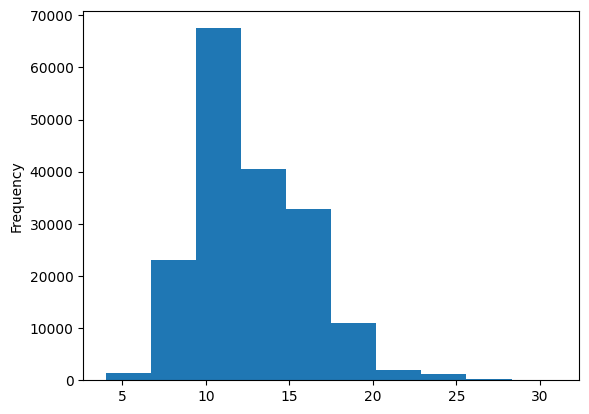

In [11]:
train_df['max'].plot.hist()

## Getting list of sentences

In [12]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

## Encode Labels

In [13]:
import sklearn

encoder = sklearn.preprocessing.OneHotEncoder()

train_onelabels = encoder.fit_transform(train_df['category'].to_numpy().reshape(-1,1))
train_onelabels = train_onelabels.toarray()
test_onelabels = encoder.fit_transform(test_df['category'].to_numpy().reshape(-1,1))
test_onelabels = test_onelabels.toarray()
val_onelabels = encoder.fit_transform(val_df['category'].to_numpy().reshape(-1,1))
val_onelabels = val_onelabels.toarray()

In [14]:
label_encoder = sklearn.preprocessing.LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['category'])
test_labels = label_encoder.fit_transform(test_df['category'])
val_labels = label_encoder.fit_transform(val_df['category'])
train_labels, len(train_labels)


(array([3, 2, 2, ..., 4, 1, 1]), 180040)

In [15]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Getting character level tokens

In [16]:
def split_chars(text):
  return " ".join(list(text))

In [17]:
train_chars = [split_chars(text) for text in train_sentences]
test_chars = [split_chars(text) for text in test_sentences]
val_chars = [split_chars(text) for text in val_sentences]
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

## create positional embeddings

In [18]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:10]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [19]:
import numpy as np

np.percentile(train_df['max'], 98)

21.0

In [20]:
train_max_one_hot = tf.one_hot(train_df['max'].to_numpy(), depth = 20)
val_max_one_hot = tf.one_hot(val_df['max'].to_numpy(), depth = 20)
test_max_one_hot = tf.one_hot(test_df['max'].to_numpy(), depth = 20)

In [21]:
train_max_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

# Creating model

In [22]:
txt_vectoriser = tf.keras.layers.TextVectorization(max_tokens = 6800,
                                                   output_sequence_length = 55)

txt_vectoriser.adapt(train_sentences)

In [23]:
embedding_layer = tf.keras.layers.Embedding(input_dim = txt_vectoriser.vocabulary_size(),
                                            output_dim = 128,
                                            embeddings_initializer = "uniform",
                                            mask_zero = True)

In [24]:
char_vectoriser = tf.keras.layers.TextVectorization(max_tokens = 60,
                                                    output_sequence_length = 290,
                                                    standardize =None)

char_vectoriser.adapt(train_chars)

In [25]:
embedding_layer_char = tf.keras.layers.Embedding(input_dim = 60,
                                                 output_dim = 25,
                                                 mask_zero = True)

In [26]:
token_inputs = tf.keras.layers.Input(shape =(1,), dtype = tf.string, name = "token_input")
token_embeddings = txt_vectoriser(token_inputs)
token_embeddings = embedding_layer(token_embeddings)
token_output = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, activation = "relu")(token_embeddings)
token_output = tf.keras.layers.GlobalAveragePooling1D()(token_output)
token_output = tf.keras.layers.Dense(64, activation = "relu")(token_output)
token_model = tf.keras.Model(token_inputs, token_output)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [27]:
char_inputs = tf.keras.layers.Input(shape =(1,), dtype = tf.string, name = "char_input")
tf.print(char_inputs)
char_embeddings = char_vectoriser(char_inputs)
tf.print(char_embeddings, summarize=-1)
char_embeddings = embedding_layer_char(char_embeddings)
tf.print(char_embeddings, summarize=-1)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(char_embeddings)
tf.print(char_bi_lstm, summarize=-1)
#char_output = tf.keras.layers.GlobalAveragePooling1D()(char_bi_lstm)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

<KerasTensor shape=(None, 1), dtype=string, sparse=False, name=char_input>
<KerasTensor shape=(None, 290), dtype=int64, sparse=False, name=keras_tensor_6>
<KerasTensor shape=(None, 290, 25), dtype=float32, sparse=False, name=keras_tensor_7>
<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_9>


In [28]:
line_n_inputs = tf.keras.layers.Input(shape = (15,), dtype=tf.float32, name = "line_number_inputs")
line_outputs = tf.keras.layers.Dense(32, activation='relu')(line_n_inputs)
line_model = tf.keras.Model(line_n_inputs, line_outputs)

In [29]:
max_lines = tf.keras.layers.Input(shape = (20,), dtype = tf.float32, name = "max_lines")
line_outputs = tf.keras.layers.Dense(32, activation='relu')(max_lines)
max_model = tf.keras.Model(max_lines, line_outputs)

In [30]:
token_char_concat = tf.keras.layers.Concatenate(name ="token_char_hybrid")([token_model.output, char_model.output])
z = tf.keras.layers.Dense(256, activation='relu')(token_char_concat)
z = tf.keras.layers.Dropout(0.5)(z)

In [31]:
everything_concat = tf.keras.layers.Concatenate(name = "everthing_combined")([z, line_model.output, max_model.output])

output_layer = tf.keras.layers.Dense(5, activation ='softmax')(everything_concat)

model = tf.keras.Model(inputs =[line_model.input,
                                max_model.input,
                                token_model.input,
                                char_model.input],
                       outputs = output_layer)

In [32]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Creating datasets

In [33]:
train_token_char_dataset = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_max_one_hot,train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_onelabels)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_dataset, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [34]:
test_token_char_dataset = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_max_one_hot,test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_onelabels)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_dataset, test_token_char_labels))

test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
val_token_char_dataset = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_max_one_hot, val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_onelabels)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_dataset, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Training model

In [36]:
hist_4 = model.fit(train_token_char_dataset,
                   epochs = 5,
                   validation_data = val_token_char_dataset,
                   callbacks =[create_tensorboard_callback("exp", "everything")])

Saving TensorBoard log files to: exp/everything/20250117-053748
Epoch 1/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 151s 25ms/step - accuracy: 0.7884 - loss: 0.9993 - val_accuracy: 0.8626 - val_loss: 0.8834
Epoch 2/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - accuracy: 0.8749 - loss: 0.8723 - val_accuracy: 0.8634 - val_loss: 0.8798
Epoch 3/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - accuracy: 0.8916 - loss: 0.8493 - val_accuracy: 0.8600 - val_loss: 0.8813
Epoch 4/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 137s 24ms/step - accuracy: 0.9069 - loss: 0.8281 - val_accuracy: 0.8518 - val_loss: 0.8955
Epoch 5/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - accuracy: 0.9213 - loss: 0.8091 - val_accuracy: 0.8484 - val_loss: 0.9033


In [37]:
model.evaluate(test_token_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8551 - loss: 0.8951


[0.8946567177772522, 0.854759693145752]

In [38]:
model_pred_classes = tf.argmax(model.predict(test_token_char_dataset), axis =1).numpy()

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


# Saving model

In [39]:
model.save("bestmodel.keras")